<a href="https://colab.research.google.com/github/arijitthegame/enformer_performer/blob/WIP/performer/tf_version/test_spe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
from typing import Optional, Tuple, Union
import functools
import numpy as np
import tensorflow as tf


class SineSPE(tf.keras.layers.Layer):
    """
    code generator for sinusoidal stochastic positional encoding.
    Args:
        num_heads: The number of attention heads.
        in_features: The number of input features per attention head.
        num_realizations: The number of realizations of the stochastic
            process (R).
        num_sines: The number of sin and cos components (K).
    """

    def __init__(
        self,
        num_heads: int = 8,
        in_features: int = 64,
        num_realizations: int = 256,
        num_sines: int = 1
    ):
        super(SineSPE, self).__init__()

        # saving dimensions
        self.num_heads = num_heads
        self.in_features = in_features
        self.num_sines = num_sines
        self.num_realizations = num_realizations
        self.code_shape = (num_heads, in_features)

    def build(self, input_shape):
        
        self.offsets = tf.Variable(
                  tf.random.normal(
                      [self.num_heads,
                      self.in_features,
                      self.num_sines]
                  ),  name='offsets'
              )
        self.freqs = tf.Variable(tf.random.normal(
                      [self.num_heads,
                      self.in_features,
                      self.num_sines]
                  ) -4 , name='freqs'
              )
      # register the parameter
        def init_gains():
          gains = tf.random.normal(
                      [self.num_heads,
                      self.in_features,
                      self.num_sines])
          return gains/(tf.math.sqrt(
          tf.norm(gains,axis=-1, keepdims=True)) / 2.)

        self.gains = tf.Variable(init_gains(), name='gains')
        super(SineSPE, self).build(input_shape)

        
        

    def call(self, shape, num_realizations=None):
        """
        Generate the code, composed of a random QBar and Kbar,
        depending on the parameters, and return them for use with a
        SPE module to actually encode queries and keys.
        Args:
            shape: The outer shape of the inputs: (batchsize, *size)
            num_realizations: if provided, overrides self.num_realizations
        """
        if len(shape) != 2:
            raise ValueError('Only 1D inputs are supported by SineSPE')

        # get shape of the queries. Here it's only 1d
        max_len = shape[1]
        
        # build omega_q and omega_k,
        # with shape (num_heads, keys_dim, length, 2*num_sines)
        indices = tf.cast(tf.linspace(0, max_len-1, max_len), dtype=float)
       # print(indices)

        # making sure the frequencies are in [0, 0.5]
        freqs = tf.math.sigmoid(self.freqs[:, :, None, :])/2.

        phases_q = (
            2 * math.pi
            * freqs * indices[None, None, :, None]
            + self.offsets[:, :, None, :]
        )
        omega_q = tf.reshape((tf.stack([tf.math.cos(phases_q), tf.math.sin(phases_q)], axis=-1)),
            [1, self.num_heads, self.in_features, max_len, 2*self.num_sines]
        )

        phases_k = (
            2 * math.pi
            * freqs * indices[None, None, :, None]
        )
        omega_k = tf.reshape((tf.stack([tf.math.cos(phases_k), tf.math.sin(phases_k)], axis=-1)),
            [1, self.num_heads, self.in_features, max_len, 2*self.num_sines]
        )

        # gains is (num_heads, keys_dim, num_sines). Making then nonnegative with softplus
        gains = tf.math.softplus(self.gains)
        print(gains.shape)

        # now upsample it
        gains = tf.reshape((tf.stack(
            (gains, gains), axis=-1)),
                [self.num_heads, self.in_features, 2*self.num_sines])

        # the number of realizations is overrided by the function argument if provided
        if num_realizations is None:
            num_realizations = self.num_realizations

        # draw noise of appropriate shape on the right device
        #print(num_realizations)
        z = tf.random.normal(
            [1, self.num_heads, self.in_features, 2 * self.num_sines,
            num_realizations]) / (math.sqrt(self.num_sines * 2))

        # scale each of the 2*num_sines by the appropriate gain
        # z is still (1, num_heads, keys_dim, 2*num_sines, num_realizations)
        z = z * gains[None, ..., None]

        # computing the sum over the sines.
        # gets (1, num_heads, keys_dim, length, num_realizations)
        qbar = tf.linalg.matmul(omega_q, z)
        kbar = tf.linalg.matmul(omega_k, z)

        # permuting them to be (1, length, num_heads, keys_dim, num_realizations)
        qbar = tf.transpose(qbar, perm = [0, 3, 1, 2, 4])
        kbar = tf.transpose(kbar, perm = [0, 3, 1, 2, 4])

        # final scaling
        scale = (num_realizations * self.in_features)**0.25
        return (qbar/scale, kbar/scale)

    def get_posattn_matrix(self, max_len=2048):
        indices = tf.linspace(0, max_len-1, max_len, device=self.freqs.device)

        # making sure the frequencies are in [0, 0.5]
        freqs = tf.math.sigmoid(self.freqs[:, :, None, :])/2.

        phases_q = (
            2 * tf.math.pi
            * freqs * indices[None, None, :, None]
            + self.offsets[:, :, None, :]
        )
        omega_q = tf.reshape((tf.stack([tf.math.cos(phases_q), tf.math.sin(phases_q)], axis=-1)),
            [1, self.num_heads, self.in_features, max_len, 2*self.num_sines]
        )

        phases_k = (
            2 * math.pi
            * freqs * indices[None, None, :, None]
        )
        omega_k = tf.stack([tf.math.cos(phases_k), tf.math.sin(phases_k)], axis=-1).view(
            1, self.num_heads, self.in_features, max_len, 2*self.num_sines
        )

        # gains is (num_heads, keys_dim, 2*num_sines). Making then nonnegative with softplus
        #
        gains = tf.math.softplus(self.gains)
        #gains = gains / torch.sqrt(gains.norm(dim=-1, keepdim=True))
        gains = tf.stack(
            (gains, gains), axis=-1).view(
                self.num_heads, self.in_features, 2*self.num_sines)

        gains_squared_diag = tf.linalg.diag(gains ** 2)

        print ('[get posattn matrix] Omega_q: {}, lambda: {}, Omega_k: {}'.format(
            omega_q.size(), gains_squared_diag.size(), omega_k.size()
        ))
        # print (gains_squared_diag[0, 0])

        # get (1, num_heads, keys_dim) attention maps, each of size (max_len, max_len)
        omega_q_mult_gains_squared_diag = tf.einsum(
            'ihdmk, hdku -> ihdmu',
            omega_q, gains_squared_diag
        )
        pos_attn_matrices = tf.einsum(
            'ihdmk, ihdnk -> ihdmn',
            omega_q_mult_gains_squared_diag, omega_k
        )
        print ('[get posattn matrix] pos_attn: {}'.format(
            pos_attn_matrices.size()
        ))

        return pos_attn_matrices



class ConvSPE(tf.keras.layers.Layer):
    """
    code generator for convolutive stochastic positional encoding.
    Args:
        ndim: The number of attention dimensions (e.g. 2 = sequence,
            3 = image).
        num_heads: The number of attention heads.
        in_features: The number of input features per attention head.
        num_realizations: The number of realizations of the stochastic
            process (R).
        kernel_size: The size of the convolution kernel.
    """

    def __init__(
        self,
        ndim: int = 2,
        num_heads: int = 9,
        in_features: int = 65,
        num_realizations: int = 257,
        kernel_size: Union[int, Tuple[int, ...]] = 201,
    ):
        super(ConvSPE, self).__init__()

        if ndim == 1:
            conv_class = tf.keras.layers.Conv1D
        elif ndim == 2:
            conv_class = tf.keras.layers.Conv2D
        elif ndim == 3:
            conv_class = tf.keras.layers.Conv3D
        else:
            raise Exception('`ndim` must be 1, 2 or 3')

        # making kernel_size a list of length dimension in any case
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size,) * ndim

        # saving dimensions
        self.ndim = ndim
        self.in_features = in_features
        self.num_heads = num_heads
        self.kernel_size = kernel_size
        self.num_realizations = num_realizations

        kernel_init = functools.partial(
            tf.random.uniform,
            minval=0.,
            maxval=1 /(math.sqrt(tf.experimental.numpy.prod(np.array(kernel_size, dtype=float))/2))
        
        )
        # create the two convolution layers
        self.conv_q = conv_class(
            filters=num_heads * in_features,
            #out_channels=num_heads * in_features,
            strides=1,
            kernel_size=kernel_size,
            padding='VALID',
            use_bias=False,
            kernel_initializer=kernel_init,
            groups=num_heads * in_features)
        self.conv_k = conv_class(
            filters=num_heads * in_features,
           # out_channels=num_heads * in_features,
            strides=1,
            kernel_size=kernel_size,
            padding='VALID',
            use_bias=False,
            kernel_initializer=kernel_init,
            groups=num_heads * in_features)
    
        

        self.code_shape = (num_heads, in_features)

    def call(self, shape, num_realizations=None):
        """
        generate the random QBar and Kbar, depending on the parameters,
        Args:
            shape: The outer shape of the inputs: (batchsize, *size)
        """
        batchsize = 1
        original_shape = shape[1:]

        # decide on the size of the signal to generate
        # (larger than desired to avoid border effects)
        shape = [4*k+s for (k, s) in zip(self.kernel_size, original_shape)]

        # the number of realizations is overrided by the function argument if provided
        if num_realizations is None:
            num_realizations = self.num_realizations

        # # draw noise of appropriate shape on the right device
        z = tf.random.normal(
            [batchsize*num_realizations,
                 *shape,
            self.num_heads * self.in_features])

        # apply convolution, get (batchsize*num_realizations, num_heads*keys_dim, *shape)
        kbar = self.conv_q(z)
        qbar = self.conv_k(z)

        # truncate to desired shape (remove the start to avoid the border effects)
        for dim in range(len(shape)):
            k = self.kernel_size[dim]
            s = original_shape[dim]

            indices = (slice(batchsize * self.num_realizations), slice(k, k+s, 1))
            qbar = qbar[indices]
            kbar = kbar[indices]

        # making (batchsize, num_realizations, num_heads, keys_dim, *shape)
        #view to reshape
        kbar = tf.reshape(kbar,[batchsize, num_realizations,
                         self.num_heads, self.in_features, *original_shape])
        qbar = tf.reshape(qbar, [batchsize, num_realizations,
                         self.num_heads, self.in_features, *original_shape])

        # permuting to be
        # (batchsize, *shape, num_heads, keys_dim, num_realizations) as desired
        qbar = tf.transpose(qbar, [0, *[x for x in range(4, self.ndim+4)], 2, 3, 1])
        kbar = tf.transpose(kbar, [0, *[x for x in range(4, self.ndim+4)], 2, 3, 1])

        # final scaling
        scale = (num_realizations * self.in_features)**0.25
        return (qbar/scale, kbar/scale)

    def get_posattn_matrix(self, shape, num_realizations=None):
        batchsize = 1
        original_shape = shape[1:]

        # decide on the size of the signal to generate
        # (larger than desired to avoid border effects)
        shape = [4*k+s for (k, s) in zip(self.kernel_size, original_shape)]

        # the number of realizations is overrided by the function argument if provided
        if num_realizations is None:
            num_realizations = self.num_realizations

        # # draw noise of appropriate shape on the right device
        # z = tf.random.normal(
        #     batchsize*num_realizations,
        #     self.num_heads * self.in_features,
        #     *shape)

        # apply convolution, get (batchsize*num_realizations, num_heads*keys_dim, *shape)
        kbar = self.conv_q(z)
        qbar = self.conv_k(z)

        for dim in range(len(shape)):
            k = self.kernel_size[dim]
            s = original_shape[dim]

            indices = [slice(batchsize*num_realizations),
                       slice(self.num_heads*self.in_features)] + [slice(k, k+s, 1), ]
            qbar = qbar[indices]
            kbar = kbar[indices]

        print ('[get posattn matrix] Qbar: {}, Kbar: {}'.format(
            qbar.size(), kbar.size()
        ))

        # get (num_heads * keys_dim) attention maps, each of size (max_len, max_len) 
        pos_attn_matrices = tf.einsum(
            'rdm, rdn -> dmn',
            qbar, kbar
        )
        print ('[get posattn matrix] pos_attn: {}'.format(
            pos_attn_matrices.size()
        ))

        # reshape attention maps to the same shape as those of SineSPE
        pos_attn_matrices = pos_attn_matrices.view(
            batchsize, self.num_heads, self.in_features, original_shape[-1], original_shape[-1]
        )

        return pos_attn_matrices



class SPEFilter(tf.keras.layers.Layer):
    """Stochastic positional encoding filter
    Applies a positional code provided by a SPE module on actual queries and keys.
    Implements gating, i.e. some "dry" parameter, that lets original queries and keys through if activated.
    Args:
    gated: whether to use the gated version, which learns to balance
        positional and positionless features.
    code_shape: the inner shape of the codes, i.e. (num_heads, key_dim),
        as given by `spe.code_shape`
    """
    def __init__(
        self,
        gated: bool = True,
        code_shape: Optional[Tuple[int, int]] = None,
    ):
        super(SPEFilter, self).__init__()

        self.gated = gated
        self.code_shape = code_shape

        # create the gating parameters if required
        if gated:
            if code_shape is None:
                raise RuntimeError('code_shape has to be provided if gated is True.')
            self.gate = tf.Variable(tf.random.normal(shape=code_shape), name='gate'
            )

    def call(
        self,
        queries: tf.Tensor,
        keys: tf.Tensor,
        code: Tuple[tf.Tensor, tf.Tensor]
    ) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Apply SPE on keys with a given code.
        Expects keys and queries of shape `(batch_size, ..., num_heads,
        key_dim)` and outputs keys and queries of shape `(batch_size,
        ..., num_heads, num_realizations)`. code is the tuple
        of the 2 tensors provided by the code instance, each one of
        shape (1, ..., num_heads, key_dim, num_realizations)
        """
        assert (queries.shape == keys.shape), \
            "As of current implementation, queries and keys must have the same shape. "\
            "got queries: {} and keys: {}".format(queries.shape, keys.shape)

        # qbar and kbar are (1, *shape, num_heads, keys_dim, num_realizations)
        (qbar, kbar) = code


        # check that codes have the shape we are expecting
        if self.code_shape is not None and qbar.shape[-3:-1] != self.code_shape:
            raise ValueError(
                f'The inner shape of codes is {qbar.shape[-3:-1]}, '
                f'but expected {self.code_shape}')

        # check shapes: size of codes should be bigger than queries, keys
        code_size = qbar.shape[1:-3]
        query_size = queries.shape[1:-2]

        #TODO: ADD THE FOLLOWING ASSERTION
        # if (len(code_size) != len(query_size)
        #     or tf.math.reduce_any(
        #         code_size < query_size
        #     )):
        #         raise ValueError(f'Keys/queries have length {query_size}, '
        #                          f'but expected at most {code_size}')
        if qbar.shape[-3:-1] != queries.shape[-2:]:
            raise ValueError(f'shape mismatch. codes have shape {qbar.shape}, '
                             f'but queries are {queries.shape}')

        # truncate qbar and kbar for matching current queries and keys,
        # but only if we need to
        for dim in range(len(query_size)):
            if code_size[dim] > query_size[dim]:
                indices = [slice(1), *[slice(qbar.shape[1+k]) for k in range(dim)],
                           slice(query_size[dim])]
                qbar = qbar[indices]
                kbar = kbar[indices]

        # apply gate if required
        if self.gated:
            # incorporate the constant bias for Pd if required. First draw noise
            # such that noise noise^T = 1, for each head, feature, realization.
            # qbar is : (1, *shape, num_heads, keys_dim, num_realizations)
            in_features = qbar.shape[-2]
            num_realizations = qbar.shape[-1]
            gating_noise = tf.random.normal(shape=
                self.code_shape+(num_realizations,)) / (in_features * num_realizations)**0.25
            # normalize it so that it's an additive 1 to Pd
            #gating_noise = gating_noise / gating_noise.norm(dim=2, keepdim=True)

            # constrain the gate parameter to be in [0 1]
            gate = tf.math.sigmoid(self.gate[..., None])

            # qbar is (1, *shape, num_heads, keys_dim, num_realizations)
            # gating noise is (num_heads, keys_dim, num_realizations)
            # gate is (num_heads, keys_dim, 1)
            #import ipdb; ipdb.set_trace()
            qbar = tf.math.sqrt(1.-gate) * qbar  + tf.math.sqrt(gate) * gating_noise
            kbar = tf.math.sqrt(1.-gate) * kbar  + tf.math.sqrt(gate) * gating_noise

        # sum over d after multiplying by queries and keys
        # qbar/kbar are (1, *shape, num_heads, keys_dim, num_realizations)
        # queries/keys  (batchsize, *shape, num_heads, keys_dim)
        qhat = tf.math.reduce_sum((qbar * queries[..., None]), axis=-2)
        khat = tf.math.reduce_sum((kbar * keys[..., None]), axis=-2)

        # result is (batchsize, ..., num_heads, num_realizations)
        return qhat, khat



In [2]:
import matplotlib.pyplot as plt

In [3]:
keys_dim = 64
num_heads = 1
num_realizations = 64
num_sines = 5
kernel_size = 20
n = 1000
batchsize=8

# sine or conv
conv = False

# number of layers to simulate
n_layers = 1

# create the positional encoder, with a specified max lag
if conv:
    poscoder = ConvSPE(ndim=1, in_features=keys_dim, kernel_size=kernel_size, num_heads=num_heads, num_realizations=num_realizations)
else:
    poscoder = SineSPE(num_heads=num_heads, in_features=keys_dim, num_sines=num_sines, num_realizations=num_realizations)


filters = []
for layer in range(n_layers):
    filters += [SPEFilter(gated=True, code_shape=poscoder.code_shape)]
    #filters[-1].gate.data[...] = layer*5.


In [4]:
q = tf.Variable(tf.random.uniform([batchsize, n, num_heads, keys_dim]))
k = tf.Variable(tf.random.uniform([batchsize, n, num_heads, keys_dim]))

In [5]:
from tqdm import tqdm

(1, 64, 5)


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


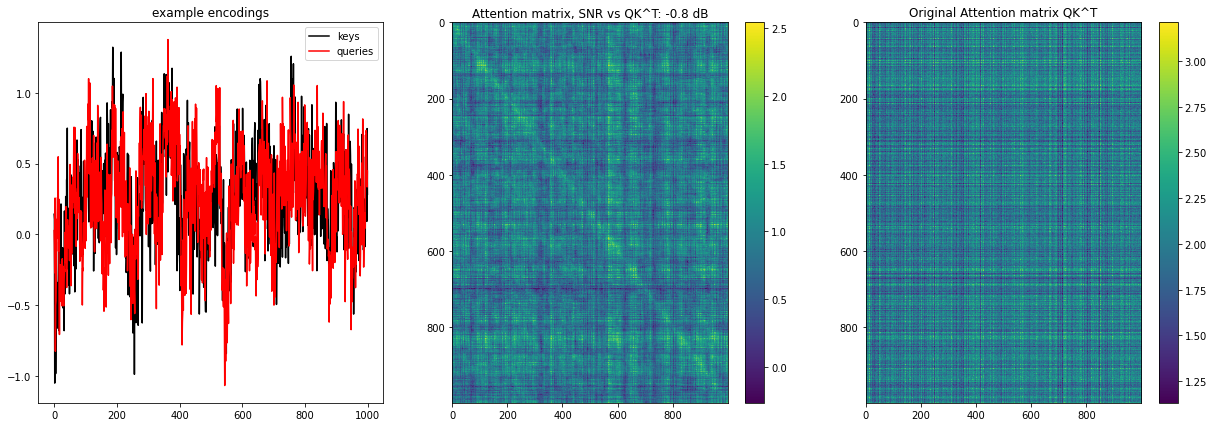

In [9]:
loss = 0
poscode = poscoder(q.shape[:2])
for iteration in tqdm(range(n_layers)):
    # compute the attention matrix
    A0 = tf.matmul(q[0,:,0,:], k[0,:,0,:], transpose_b=True) / math.sqrt(keys_dim)

    # apply SPE
    q, k = filters[iteration](q,k, poscode)

    # compute corresponding attention matrix
    A = tf.matmul(q[0,:,0,:], k[0,:,0,:], transpose_b=True) / math.sqrt(num_realizations)

    # compute a loss to check backward
    loss = loss + tf.math.reduce_sum(A, axis=None)

# display some queries and keys
q = q.numpy()
k = k.numpy()

plt.figure(figsize=[21,7]);
plt.subplot(131)
plt.plot(k[0,:,0,0],'k');
plt.plot(q[0,:,0,0],'r');
plt.title('example encodings');
plt.legend(['keys', 'queries']);

# display the average dot product
plt.subplot(132);
plt.imshow(A.numpy(), aspect='auto', interpolation='nearest');
plt.title('Attention matrix, SNR vs QK^T: %0.1f dB'%(10*tf.experimental.numpy.log10(tf.norm(A)/tf.norm(A-A0))));
plt.colorbar();

plt.subplot(133);
plt.imshow(A0.numpy(), aspect='auto', interpolation='nearest');
plt.title('Original Attention matrix QK^T');
plt.colorbar();